# Импортируем нужные библиотеки

In [2]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import model_selection, datasets, metrics, tree, ensemble
from scipy.interpolate import griddata

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns

import time

# Готовим данные

Генерируем выборку с помощью sklearn.datasets.make_regression (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) со следующими параметрами:
1. Наблюдений - 10 тысяч
2. Всех фичей - 100
3. Информативных фичей - 50

In [3]:
regression_problem = datasets.make_regression(n_samples=10000, n_features=100,
                                              n_informative=50, random_state=42)

In [4]:
regression_problem[0].shape

(10000, 100)

Разбиваем выборку на **train** и **test** в отношении 75:25.

In [5]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_problem[0],
                                                                                    regression_problem[1],
                                                                                    test_size=0.25,
                                                                                    random_state=42)

# Строим модели

Рассматривается задача **регрессии**: по исходным признакам требуется восстановить непрерывный таргет.

**Цель**: минимизировать метрику **MSE** (среднеквадратическая ошибка).

В качестве максимальной ошибки будем рассматривать алгоритм, который выдает в качестве ответа константу - среднее значение таргета на обучающей выборке.

In [6]:
round(metrics.mean_squared_error(test_labels, test_labels.shape[0] * [train_labels.mean()]))

147370

## Дерево решений

***Задание 1.***

Требуется обучая деревья решений на трейне, подобрать гиперпараметры **max_depth** и **min_samples_leaf** так, чтобы **MSE** на тесте было меньше **130 000**. При этом разница в качестве на обучающей и тестовой выборках должно различаться не более, чем на **15 000**.

In [71]:
tree_regressor = tree.DecisionTreeRegressor(max_depth=6, min_samples_leaf=195,
                                            random_state=42)
tree_regressor.fit(train_data, train_labels)
predictions = tree_regressor.predict(train_data)
train_tree_MSE = metrics.mean_squared_error(train_labels, predictions)
predictions = tree_regressor.predict(test_data)
test_tree_MSE = metrics.mean_squared_error(test_labels, predictions)
if (test_tree_MSE < 130000) and (test_tree_MSE - train_tree_MSE <= 15000):
    print('Вы восхитительны!')
print(test_tree_MSE, train_tree_MSE)

Вы восхитительны!
125100.78923430624 115627.22525606772


***Задание 2.***

Расскажите, почему вы выбрали именно эти значения для гиперпараметров?

Ответ: 
Эксперименты показали, что при max_depth > 5 происходит резкое переобучение на тренировочной выборке, поэтому было решено оставить max_depth = 5 

min_samples_leaf > 50 снижает разницу в качестве между выборками, но одновременно и ухудшает их

ОДНАКО можно использовать количество информативных признаков и подобрать так, чтобы число узлов могло быть достигнуто (max_depth >= 6) и ограничить разбиение с помощью увеличения min_samples_leaf

***Задание 3.***

Визуализируйте построенное дерево. Можно воспользоваться методом, который был продемонстрирован на семинаре.

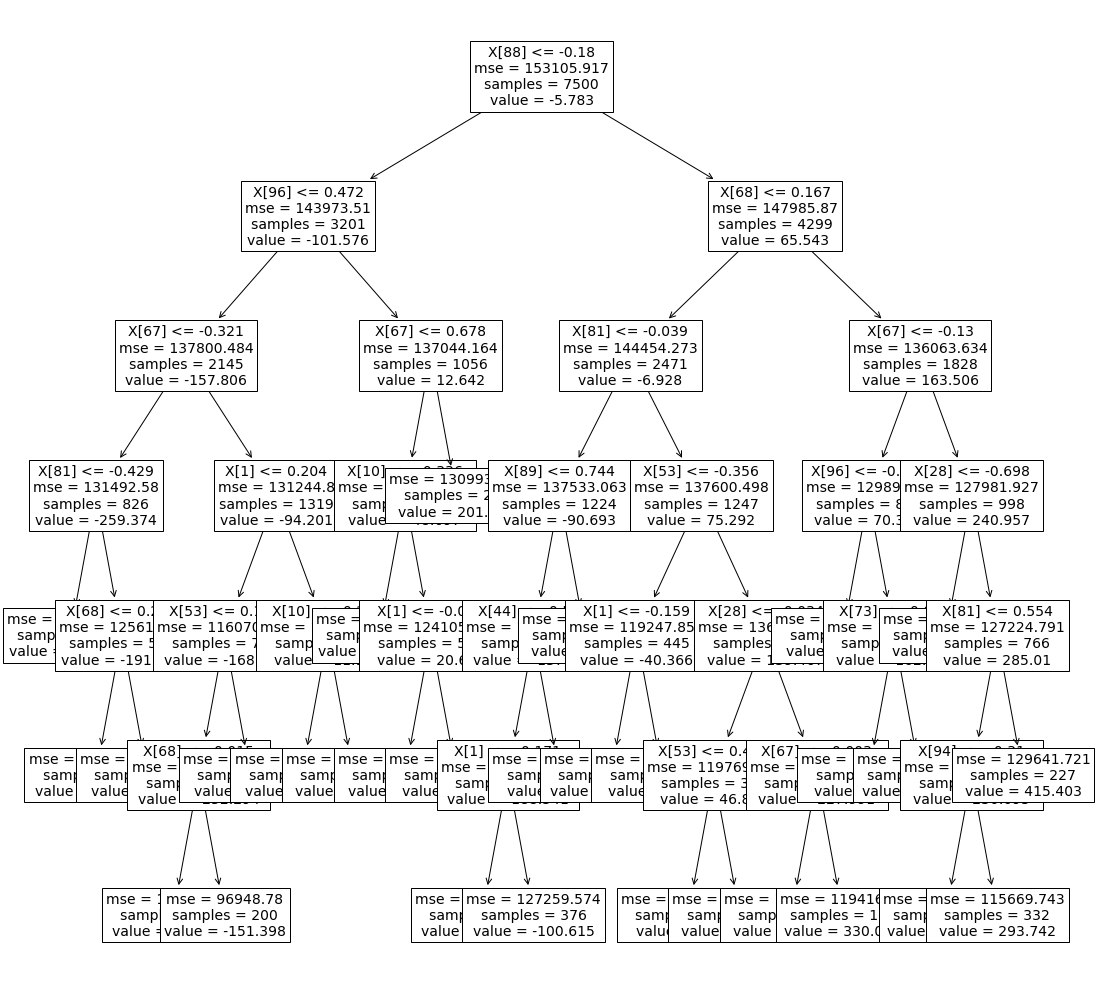

In [72]:
plt.figure(figsize = (18, 18))
txt = tree.plot_tree(tree_regressor, fontsize=14)

***Задание 4.***

Далее посмотрим, как работает построенное дерево. Для этого выберем 2 самых значимых для дерева признака и визуализируем сплиты по ним. Можете использовать как указанную ниже функции функции, так и собственно написанные.

Нужно выбрать 2 признака и выполнить функцию для обучающей и тестовой выборок.

In [78]:
def plot_decision_surface(i, j, data, labels, split_1, split_2, left_flg):
    """
        i - номер первого признака
        j - номер второго признака
        data - выборка с признаками
        labels - выборка с таргетом
        split_1 - значение из условия на первый признак
        split_2 - значение из условия на второй признак
        left_flg - флаг того, что второй признак рассматривается при невыполнении
        в дереве условия на первый признак
    """
    x = data[:, i]
    y = data[:, j]
    z = labels
    
    resolution = '50j'
    X, Y = np.mgrid[min(x):max(x):complex(resolution), min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method='linear')

    plt.figure(figsize=(14, 10))
    plt.contourf(X, Y, Z, cmap='winter')
    plt.colorbar()
    plt.plot([split_1, split_1], [y.min(), y.max()], 'r', linewidth=5, label='First split')
    if left_flg:
        split_list = [x.min(), split_1]
    else:
        split_list = [split_1, x.max()]
    plt.plot(split_list, [split_2, split_2], 'm', linewidth=5, label='Second split')
    plt.legend()
    plt.xlabel(f'X[{i}]')
    plt.ylabel(f'X[{j}]')
    plt.show()

In [73]:
feats = {}
for feature, importance in enumerate(tree_regressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances.head(15)

,Features,Gini-Importance
0,88,0.182304
1,67,0.153475
2,68,0.141638
3,81,0.105004
4,96,0.101572
5,1,0.088746
6,53,0.060420
7,28,0.046136
8,10,0.039732
9,89,0.031703


In [74]:
first_feature_number = 88
second_feature_number = 67

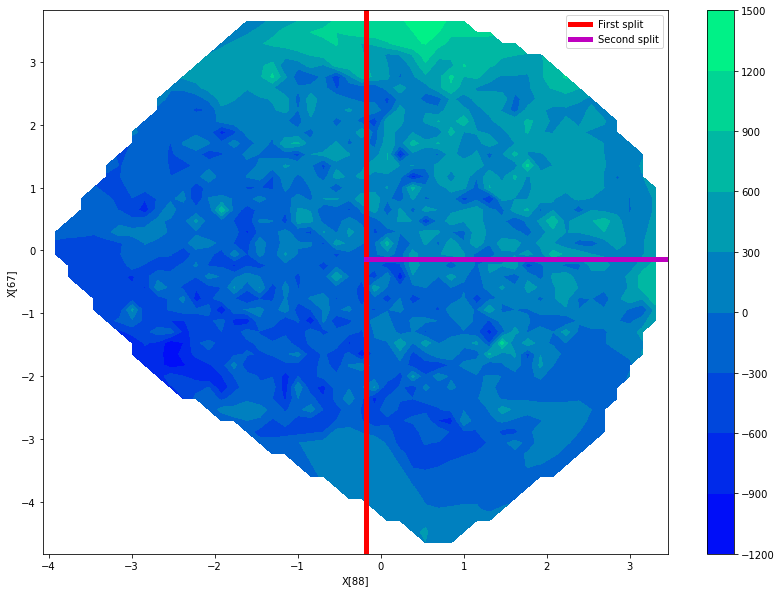

In [86]:
plot_decision_surface(first_feature_number, second_feature_number, train_data, train_labels, -0.18, -0.13, False)

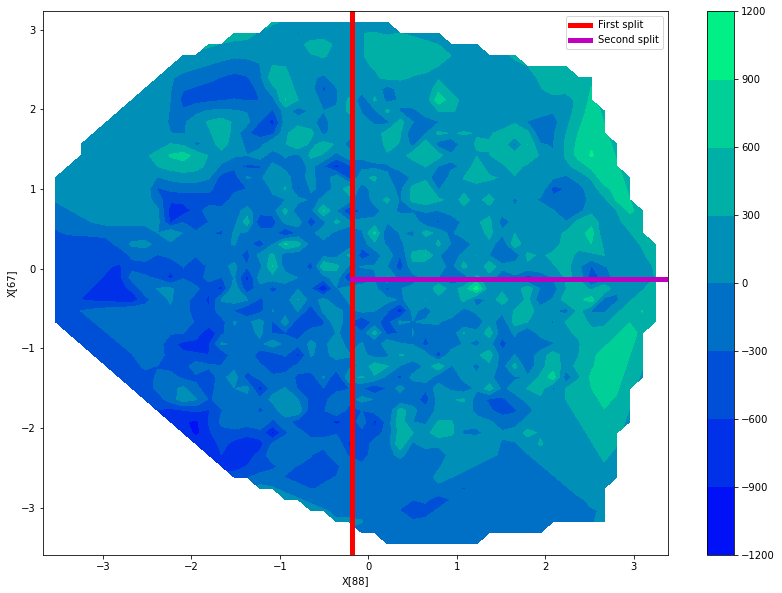

In [84]:
plot_decision_surface(first_feature_number, second_feature_number, test_data, test_labels, -0.18, -0.13, False)

Как вы оцениваете разбиение выборок по двум сплитам из дерева?

Ответ: Первый сплит достаточно точно разбивает пространство объектов на области, где преобладают меньшие и большие значения таргета (слева и справа соответственно).
Второй сплит хорошо работает на тренировочной выборке, однако польза на тестовой выборке минимальна.

## Случайный лес

***Задание 5.***

Задание, аналогичное второму:

Требуется обучая случайные леса на трейне, подобрать гиперпараметры **n_estimators**, **max_depth** и **min_samples_leaf** так, чтобы **MSE** на тесте было меньше **100 000**. При этом разница в качестве на обучающей и тестовой выборках должно различаться не более, чем на **15 000**.

In [243]:
forest_regressor = ensemble.RandomForestRegressor(n_estimators=51, max_depth=12, min_samples_leaf=33,
                                                  max_features='sqrt', random_state=42)
forest_regressor.fit(train_data, train_labels)
predictions = forest_regressor.predict(train_data)
train_forest_MSE = metrics.mean_squared_error(train_labels, predictions)
predictions = forest_regressor.predict(test_data)
test_forest_MSE = metrics.mean_squared_error(test_labels, predictions)
if (test_forest_MSE < 100000) and (test_forest_MSE - train_forest_MSE <= 15000):
    print('Вы прекрасны!!')
print(train_forest_MSE, test_forest_MSE)

Вы прекрасны!!
80527.83364203127 95190.2923126519


***Задание 6.***

Расскажите, почему вы выбрали именно эти значения для гиперпараметров?

Ответ: Делая на ноутбуке, я ограничен во времени и следовательно, в использовании эстиматоров, зато увеличение глубины и уменьшение минимальное порога объекта листьев позволило добиться лучших результатов с сохранением малого переобучения

***Задание 7.***

Выведите топ-10 по значимости признаков построенного дерева.

In [244]:
feats = {}
for feature, importance in enumerate(forest_regressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances.head(15)

,Features,Gini-Importance
0,88,0.079092
1,67,0.067263
2,1,0.059873
3,81,0.056539
4,68,0.051253
5,89,0.050415
6,10,0.050223
7,53,0.050076
8,96,0.044477
9,41,0.036420


Два самых значимых признака дерева решений из пятого задания присутствуют в списке выше?

Ответ: да

## Градиентный бустинг LGBM

***Задание 8.***

Снова требуется обучая теперь уже градиентный бустинги на трейне, подобрать гиперпараметры **n_estimators**, **max_depth** и **learning_rate** так, чтобы **MSE** на тесте было меньше **42 000**. При этом разница в качестве на обучающей и тестовой выборках должно различаться не более, чем на **10 000**.

In [430]:
LGBM_regressor = lgb.LGBMRegressor(n_estimators=50, max_depth=2, learning_rate=0.43,
                                           random_state=42)
LGBM_regressor.fit(train_data, train_labels)
predictions = LGBM_regressor.predict(train_data)
train_LGBM_MSE = metrics.mean_squared_error(train_labels, predictions)
predictions = LGBM_regressor.predict(test_data)
test_LGBM_MSE = metrics.mean_squared_error(test_labels, predictions)
if (test_LGBM_MSE < 42000) and (test_LGBM_MSE - train_LGBM_MSE <= 10000):
    print('Вы чудесны!!!')
print(train_LGBM_MSE, test_LGBM_MSE)

Вы чудесны!!!
30956.23766982515 40855.15337383263


***Задание 9.***

Расскажите, почему вы выбрали именно эти значения для гиперпараметров?

Ответ:

В отличие от случайного леса, кол-во эстиматоров не компенсирует максимальной глубины каждого из них - поэтому необходимо снизить max_depth.
Learning rate выбран перебором

***Задание 10.***

Выведите топ-10 по значимости признаков построенного бустинга.

In [431]:
feats = {}
for feature, importance in enumerate(LGBM_regressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances.head(15)

,Features,Gini-Importance
0,89,8
1,1,7
2,10,7
3,28,7
4,67,7
5,73,7
6,81,7
7,53,7
8,19,6
9,41,6


Два самых значимых признака дерева решений из пятого задания присутствуют в списке выше? Насколько данный топ совпадает с топом, полученным для случайного леса?

Ответ: топ полностью не совпадает со случайным лесом

Ответ:

***Задание 11.***

Не меняя гиперпараметры **max_depth** и **learning_rate**, постройте зависимость **MSE** от числа деревьев, обучая для каждого значения **n_estimators** новый бустинг. **MSE** нужно подсчитать для обучающей и тестовой выборок.

Изобразите полученные зависимости на графике (ось Оx - **n_estimators**, ось Оy - **MSE**). Должно получится 2 линии, каждая из которых соответствует качеству на трейне и тесте.

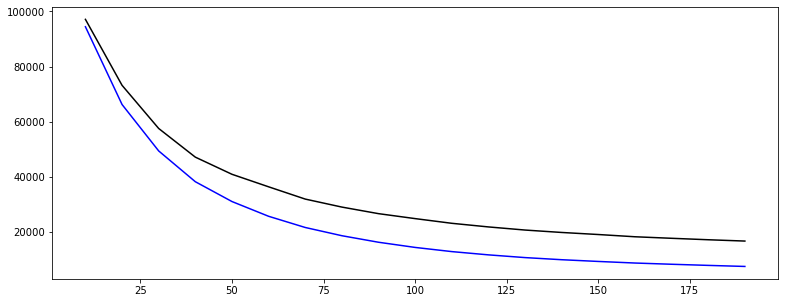

In [439]:
Train_MSE = []
Test_MSE = []
n_es = range(10, 200,10)
for n_e in n_es:
    LGBM_regressor = lgb.LGBMRegressor(n_estimators=n_e, max_depth=2, learning_rate=0.43,
                                               random_state=42)
    LGBM_regressor.fit(train_data, train_labels)
    predictions = LGBM_regressor.predict(train_data)
    train_LGBM_MSE = metrics.mean_squared_error(train_labels, predictions)
    predictions = LGBM_regressor.predict(test_data)
    test_LGBM_MSE = metrics.mean_squared_error(test_labels, predictions)
    Train_MSE.append(train_LGBM_MSE)
    Test_MSE.append(test_LGBM_MSE)
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(n_es, Train_MSE, c='b')
ax.plot(n_es, Test_MSE, c='k')

Какой вывод можно сделать из графика? Что будет, если выбрать **n_estimators** меньшее или большее относительно того, которое вы получили в десятом задании?

Ответ: Увеличения n_estimators после некоторого значения всё слабее и слабее влияет на улудшение выборки, поэтому после 50 наблюдается сильный спад "полезности" гиперпараметра

В случае возникновения вопросов по заданиям обращайтесь в общий чат.